In [ ]:
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/



In [ ]:
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d msambare/fer2013

 96% 58.0M/60.3M [00:00<00:00, 145MB/s]
100% 60.3M/60.3M [00:00<00:00, 145MB/s]


In [ ]:
!unzip -qq fer2013.zip

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import numpy as np
import os
import datetime
%matplotlib inline

In [ ]:
imagePaths = "train"
test_path="test"

In [ ]:
!ls -al test

total 356
drwxr-xr-x 9 root root  4096 May 29 10:47 .
drwxr-xr-x 1 root root  4096 May 29 10:47 ..
drwxr-xr-x 2 root root 45056 May 29 10:47 angry
drwxr-xr-x 2 root root  4096 May 29 10:47 disgust
drwxr-xr-x 2 root root 57344 May 29 10:47 fear
drwxr-xr-x 2 root root 73728 May 29 10:47 happy
drwxr-xr-x 2 root root 61440 May 29 10:47 neutral
drwxr-xr-x 2 root root 69632 May 29 10:47 sad
drwxr-xr-x 2 root root 40960 May 29 10:47 surprise


In [ ]:
tf.keras.utils.set_random_seed(1234)

In [ ]:
batch_size=64
img_height = 48
img_width = 48

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths,
  #color_mode='grayscale',
  validation_split=0.15,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.
Using 24403 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths,
  #color_mode='grayscale',
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.
Using 4306 files for validation.


In [ ]:

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  #seed=123,
  image_size=(img_height, img_width),
  #label_mode="categorical",
  batch_size=batch_size)

Found 7178 files belonging to 7 classes.


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(64, 48, 48, 3)
(64,)
64
64


In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.015686275 0.91372555


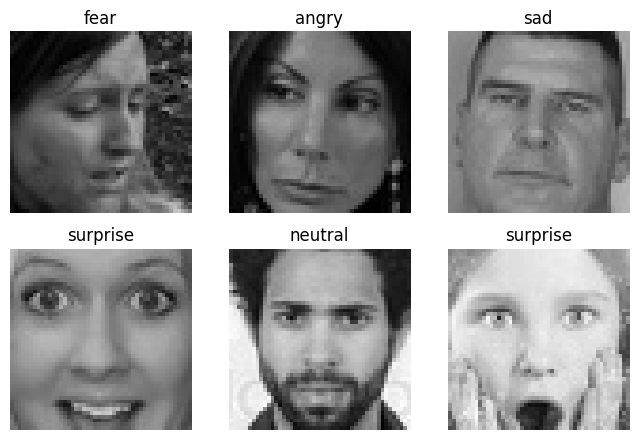

In [ ]:

class_names = train_ds.class_names
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
data_augmentation= Sequential([
                               layers.RandomFlip("horizontal"),
                               layers.RandomBrightness(factor=0.1, value_range=(0, 255), seed=123)
])

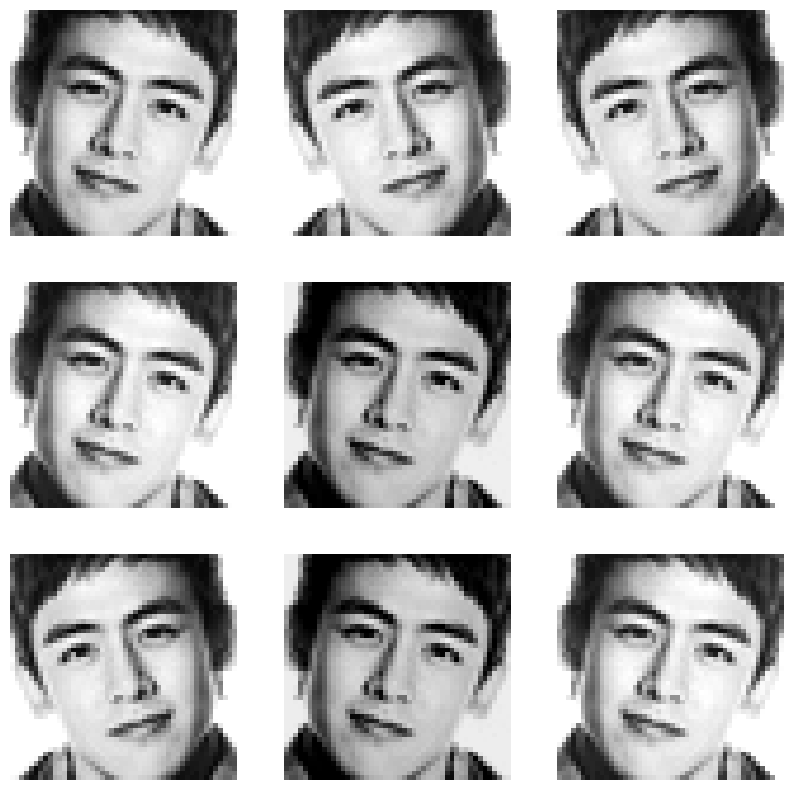

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(2,2), activation='relu', input_shape=(48,48,3)))
model.add(Conv2D(256, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.30))

model.add(Conv2D(128, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.30))

model.add(Conv2D(128, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.30))

model.add(Conv2D(128, kernel_size=(2,2), activation='relu'))


model.add(Conv2D(128, kernel_size=(2,2), activation='relu'))
model.add(Conv2D(128, kernel_size=(2,2), activation='relu'))

model.add(Conv2D(64, kernel_size=(2,2), activation='relu'))

model.add(Dropout(0.30))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='softmax'))


In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 47, 47, 32)        416       
                                                                 
 conv2d_59 (Conv2D)          (None, 46, 46, 256)       33024     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 23, 23, 256)      0         
 g2D)                                                            
                                                                 
 dropout_44 (Dropout)        (None, 23, 23, 256)       0         
                                                                 
 conv2d_60 (Conv2D)          (None, 22, 22, 128)       131200    
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 11, 11, 128)      0         
 g2D)                                                

In [ ]:
def get_early_stopping():

    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:

def get_checkpoint_best_only():

    checkpoint_best_path= 'checkpoints_best_only'
    checkpoint_best= ModelCheckpoint(filepath=checkpoint_best_path,
                           frequency='epoch',
                           save_weights_only=False,
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    return checkpoint_best


In [ ]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#callbacks = [checkpoint_best_only, early_stopping, tensorboard_callback]
callbacks = [checkpoint_best_only, tensorboard_callback, early_stopping]

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed.
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)

    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1

    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [ ]:
y_train= tf.concat([y for x, y in train_ds], axis=0)

In [ ]:
class_weights = generate_class_weights(y_train.numpy())

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=50, class_weight=class_weights, callbacks=callbacks)


Epoch 1/50
382/382 [==============================] - ETA: 0s - loss: 2.4507 - accuracy: 0.1411
Epoch 1: val_accuracy did not improve from 0.46516
382/382 [==============================] - 19s 40ms/step - loss: 2.4507 - accuracy: 0.1411 - val_loss: 2.2426 - val_accuracy: 0.1398
Epoch 2/50
381/382 [============================>.] - ETA: 0s - loss: 2.0106 - accuracy: 0.1265
Epoch 2: val_accuracy did not improve from 0.46516
382/382 [==============================] - 15s 39ms/step - loss: 2.0103 - accuracy: 0.1265 - val_loss: 1.9681 - val_accuracy: 0.1681
Epoch 3/50
381/382 [============================>.] - ETA: 0s - loss: 1.9733 - accuracy: 0.1184
Epoch 3: val_accuracy did not improve from 0.46516
382/382 [==============================] - 15s 40ms/step - loss: 1.9730 - accuracy: 0.1183 - val_loss: 1.9460 - val_accuracy: 0.1725
Epoch 4/50
381/382 [============================>.] - ETA: 0s - loss: 1.9623 - accuracy: 0.1238
Epoch 4: val_accuracy did not improve from 0.46516
382/382 [====

In [ ]:
model.load_weights("checkpoints_best_only")


In [ ]:
model.evaluate(test_ds)


113/113 [==============================] - 1s 11ms/step - loss: 1.4077 - accuracy: 0.4707


[1.4076967239379883, 0.47074395418167114]

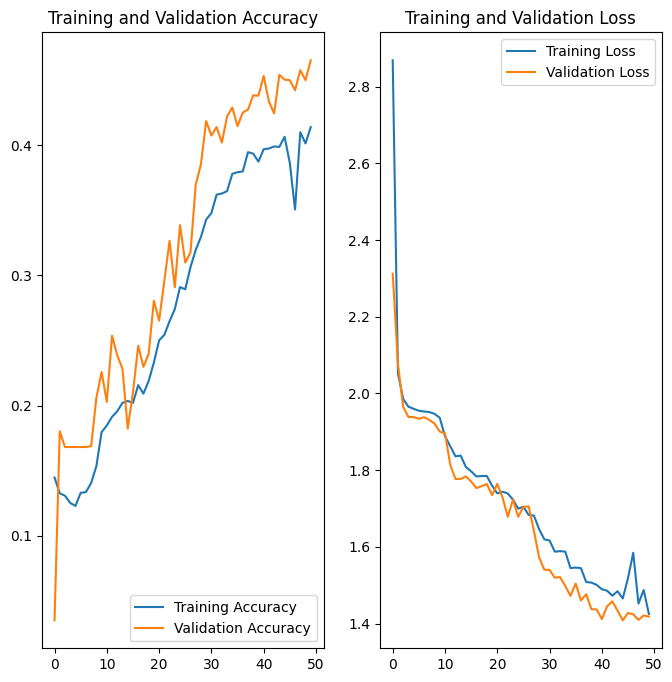

In [ ]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:

predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  Y_pred=model.predict(x)
  y_prediction = np.argmax(Y_pred, axis=1)
  predictions = np.concatenate([predictions, y_prediction])
  labels = np.concatenate([labels, y.numpy()])

1/1 [==============================] - 0s 87ms/step


In [ ]:
print('Confusion Matrix')
print(confusion_matrix(y_true=labels, y_pred=predictions))

Confusion Matrix
[[ 210  101   67   65  160  289   66]
 [   7   76    5    3    6   13    1]
 [ 117   48   98   67  179  284  231]
 [  57   17   34 1255  102  212   97]
 [  43   33   47   94  558  404   54]
 [  80   56   64   87  314  591   55]
 [  18    4   48   25   20   45  671]]


In [ ]:
classes= ['angry', 'disgust' , 'fear' , 'happy' , 'neutral' , 'sad', 'surprise']

[[ 210  101   67   65  160  289   66]
 [   7   76    5    3    6   13    1]
 [ 117   48   98   67  179  284  231]
 [  57   17   34 1255  102  212   97]
 [  43   33   47   94  558  404   54]
 [  80   56   64   87  314  591   55]
 [  18    4   48   25   20   45  671]]


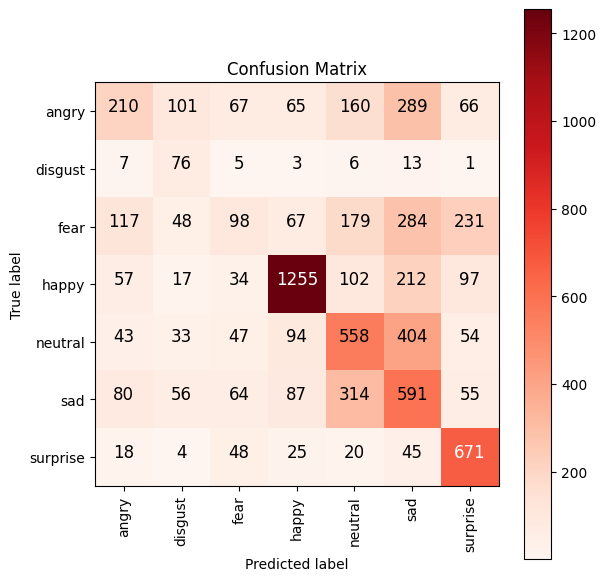

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Reds):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
#get confusion matrix
cm = confusion_matrix(labels, predictions)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

In [ ]:
print('Classification Report')
target_names = classes
print(classification_report(y_true=labels, y_pred=predictions, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       angry       0.39      0.22      0.28       958
     disgust       0.23      0.68      0.34       111
        fear       0.27      0.10      0.14      1024
       happy       0.79      0.71      0.74      1774
     neutral       0.42      0.45      0.43      1233
         sad       0.32      0.47      0.38      1247
    surprise       0.57      0.81      0.67       831

    accuracy                           0.48      7178
   macro avg       0.43      0.49      0.43      7178
weighted avg       0.48      0.48      0.47      7178



In [ ]:
model.save("brain_model.h5")


In [ ]:
for i in model.layers:
  print(i.name)

conv2d
conv2d_1
max_pooling2d
dropout
conv2d_2
max_pooling2d_1
dropout_1
conv2d_3
max_pooling2d_2
dropout_2
conv2d_4
max_pooling2d_3
dropout_3
flatten
dense
dropout_4
dense_1


In [ ]:
def get_img_array(img_path, target_size):
  img = keras.utils.load_img(img_path, target_size=target_size)
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  return array

In [ ]:

img_path = tf.keras.utils.get_file("face.jpg",
    "https://i.pinimg.com/originals/b2/41/4f/b2414f826f6a7df83e49b69b0474ef14.jpg"
)

23358/23358 [==============================] - 0s 0us/step


In [ ]:
img_array = get_img_array(img_path, target_size=(48, 48))


In [ ]:
preds = model.predict(test_ds)
print("Predicted:", preds[0])
y_pred_classes = np.argmax(preds, axis=1) # pick the highest probability with "np.argmax()", and turn it into an index uing "axis=1"


113/113 [==============================] - 2s 13ms/step
Predicted: [1.7979626e-01 1.0643876e-02 2.4624111e-01 1.2970860e-01 4.3296941e-02
 7.6535307e-02 3.1377798e-01 1.6763677e-19 3.5151200e-19 4.2349822e-20
 2.2205470e-19 2.6108644e-16 7.5361985e-22 4.1462974e-19 6.4821337e-20
 7.5439649e-22 2.4404250e-17 4.7132315e-20 1.6885235e-19 2.4169312e-16
 9.7757901e-18 4.2233739e-24 4.9053295e-18 3.4712206e-15 3.3332648e-15
 4.3468905e-19 1.5401228e-21 9.0331744e-16 8.9507980e-20 2.2486489e-21
 6.6675708e-20 9.9872689e-22]


In [ ]:
random_num = np.random.choice(len(x_test))
X_sample = x_test[random_num]

# save true label of this sample in a variable
y_true = np.argmax(y_test, axis=1)
y_sample_true = y_true[random_num]

# save a predicted label of this sample in a variable
y_sample_pred_class = y_pred_classes[random_num]

IndexError: ignored

In [ ]:
class_names = train_ds.class_names
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
import cv2
from numpy import asarray

test_img = cv2.imread("/content/test/happy/PrivateTest_10077120.jpg")
dim = (48, 48)

# resize image
test_img = cv2.resize(test_img, dim)

test_img_arr = asarray(test_img)
test_img_arr=np.reshape(test_img, (-1, 48 , 48, 3))

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f926c373a30>)

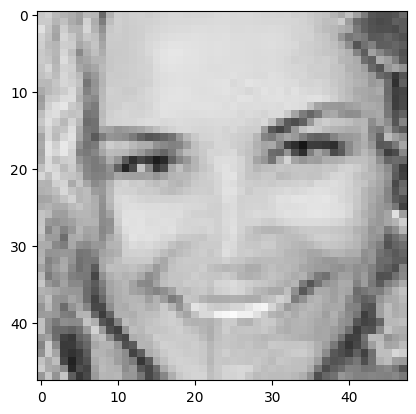

In [ ]:
plt.figure(), plt.imshow(test_img,cmap='gray')

In [ ]:
preds = model.predict(test_img_arr)
print("Predicted:", preds[0])


1/1 [==============================] - 0s 84ms/step
Predicted: [2.5232349e-02 2.9376383e-06 1.6028533e-02 9.0899110e-01 3.2059863e-02
 1.4335788e-02 3.3494970e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.6749988e-38 0.0000000e+00 0.0000000e+00 1.8396801e-33
 0.0000000e+00 0.0000000e+00 0.0000000e+00 6.3165447e-35 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00]


In [ ]:
y_pred_classes = np.argmax(preds, axis=1) # pick the highest probability with "np.argmax()", and turn it into an index uing "axis=1"
y_true = np.argmax(test_img_arr, axis=1)
y_sample_pred_class = y_pred_classes[np.where(test_img_arr)[0][0]]
tahmin = classes[y_sample_pred_class]
tahmin

'happy'

In [ ]:
y_sample_true = y_true[np.where(test_img_arr==np.argmax(y_true))[0][0]]
y_sample_true



array([[ 2,  2,  2],
       [17, 17, 17],
       [12, 12, 12],
       [17, 17, 17],
       [16, 16, 16],
       [13, 13, 13],
       [ 2,  2,  2],
       [41, 41, 41],
       [14, 14, 14],
       [14, 14, 14],
       [24, 24, 24],
       [27, 27, 27],
       [29, 29, 29],
       [27, 27, 27],
       [29, 29, 29],
       [ 5,  5,  5],
       [ 5,  5,  5],
       [ 5,  5,  5],
       [ 5,  5,  5],
       [ 5,  5,  5],
       [38, 38, 38],
       [12, 12, 12],
       [12, 12, 12],
       [39, 39, 39],
       [39, 39, 39],
       [39, 39, 39],
       [39, 39, 39],
       [39, 39, 39],
       [38, 38, 38],
       [38, 38, 38],
       [11, 11, 11],
       [10, 10, 10],
       [26, 26, 26],
       [24, 24, 24],
       [24, 24, 24],
       [26, 26, 26],
       [26, 26, 26],
       [24, 24, 24],
       [24, 24, 24],
       [26, 26, 26],
       [25, 25, 25],
       [20, 20, 20],
       [22, 22, 22],
       [21, 21, 21],
       [43, 43, 43],
       [41, 41, 41],
       [26, 26, 26],
       [27, 2

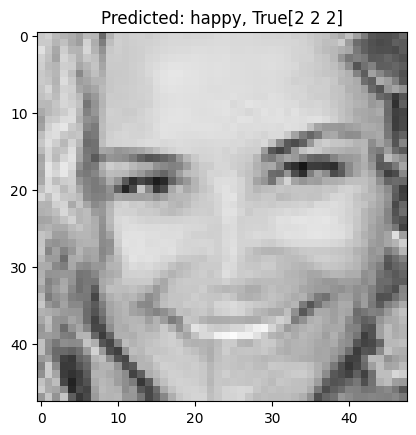

In [ ]:
plt.title(f"Predicted: {tahmin})
plt.imshow(test_img, cmap="gray");